In [1]:
import numpy as np
import scipy.special as sps
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Problem 1

We implement the Trapezoidal rule for numerically solving ODEs, and we increase its accuracy by implementing and applying Repeated Richardson Extraplolation. We then apply our methods to a specific example and examine the results.

We begin by defining a function below that will convert a higher-order linear ODE into a linear system of first-order ODEs.

In [4]:
'''
convertToSys converts a higher order ODE into a system of first 
order equations.

NOTE: One can generalize this to coupled sets of equations, but this
is not currently implemented

NOTE: We assume the form is y^(k) + f(t, y^(k-1), ..., y) = F(t)

Input:
    Y -> Function of t where element i is g(t)*y^(i) for some g
    F -> RHS of system
    order -> Order of the system
Output:
    func -> RHS of vector equation y'=f(t,y)
'''
def convertToSys(Y, F, order):
    def A(t):
        A = np.diag(np.ones(order-1), 1)
        A[order-1, :] = -Y(t)
        
        return A
        
    def b(t):
        b = np.zeros(order)
        b[order-1] = F(t)
        
        return b
        
    return (A, b)

Next, we define a function to solve the system of equations that is implicit in the Trapezoidal method.

In [5]:
'''
impSolve will solve the system of equations required in a implicit
Trapezoidal ODE solver assuming a linear system of ODEs.

NOTE: We assume the form is A(t)*y + b(t) = f(t,y) = y'(t)

Input:
    A(t) -> See above
    b(t) -> See above
    y0 -> Past point
    t0 -> Past time point
    t1 -> Future time point
Output:
    y -> Next point
'''
def impSolve(A, b, y0, t0, t1):
    h = t1-t0
    
    LHS = np.eye(y0.shape[0]) - (h/2)*A(t1)
    RHS = y0 + h*((1/2)*A(t0)@y0 + b(t0) + b(t1))
    
    return np.linalg.solve(LHS, RHS)

Finally, we define our Trapezoidal method which takes in a linear system of first-order ODEs, an initial condition, a solution interval, a stepsize, and computes the solution.

In [45]:
'''
odeTrap implements the Trapezoidal rule for solving first order
initial value ODE systems.

NOTE: Assumes vector input (i.e. >=1 dimensional system)
NOTE: Assumes linear system but not necessarily homogenous

Input:
    f -> RHS of the ODE. Either f(t,y) = A(t)*y + b(t) or f such that
        y_n+1 = f(t_n, y_n) (i.e. no longer implicit)
    y0 -> Initial condition
    interval -> Solution interval, [t0, T]
    h -> Stepsize (optional)
    last -> Return solution sequence or last iterate
Output:
    y -> Computed solution on interval
'''
def odeTrap(f, y0, interval, h=1e-2, last=False):
    if callable(f):
        future = lambda x : f(x[0], x[1], x[2])
    else:
        future = lambda x : impSolve(f[0], f[1], x[0], x[1], x[2])
        
    t = np.arange(interval[0], interval[1]+h, h)
    pts = len(t)
    
    y = np.zeros((y0.shape[0], pts))
    y[:,0] = y0
    
    for i in range(1, pts):
        y[:,i] = future((y[:,i-1], t[i-1], t[i]))
      
    if last:
        return y[0,-1]
    else:
        return y

We would like to test that our methods defined above are valid, so we consider the following cannonical test problem:

$$ y'(t)=\lambda y(t),\:y(0)=y_0 $$

Which has the solution $y(t)=y_0e^{\lambda t}$. We define this below, (trivially) convert it to a system, and then solve it with our Trapezoidal method.

In [46]:
a = 1
y0 = np.array([1])

test_Y = lambda t : np.array([-a])
test_F = lambda t: 0

f = convertToSys(test_Y, test_F, 1)

h = 1e-1
t = np.arange(0, 2+h, h)
y = odeTrap(f, y0, [0,2], h=h)

Total Error: 0.023543470568709382


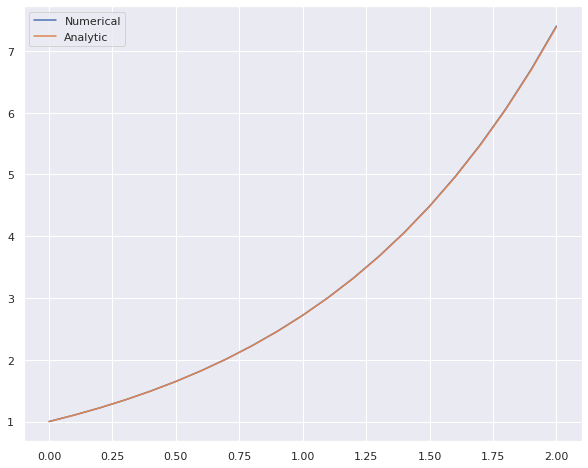

In [47]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
ax.plot(t, y[0,:])
ax.plot(t, np.exp(a*t))
ax.legend(['Numerical', 'Analytic']);
print('Total Error: {}'.format(np.linalg.norm(np.exp(a*t)-y[0,:])))

Great! The numerically solution is barely even visible as it is covered by the analytic solution, but it is there. We see that our error is $\mathcal{O}(10^{-2})$ which is expected for a second-order method with stepsize $0.1$, so everything is working well.

Lastly, we implement the Repeated Richardson Extrapolation for an arbitrary approximation method. In this case that will be our Trapezoidal method.

In [48]:
'''
extraRich implements Repeated Richardson Extrapolation to improve
the accuracy of a given approximation method.

Input:
    F -> Approximation method
    kw -> Keyword arguments for F
    h0 -> Initial stepsize
    q -> Change in step (e.g h/q)
    p -> Form of the order (e.g. p_k = 2k)
    maxitr -> Maximum number of iterations
    tol -> Requested precision
'''
def extraRich(F, kw, h0, q, p, maxitr=20, tol=1e-6):
    A = np.zeros((maxitr, maxitr))
    
    A[0,0] = F(**kw, h=h0)
    
    for m in range(1, maxitr):
        A[m,0] = F(**kw, h=h0*(q**-m))
        
        for k in range(1, m+1):
            A[m,k] = A[m, k-1]+(A[m,k-1]-A[m-1,k-1])/(q**(p*k) - 1)
                
            if k<m and np.abs(A[m,k]-A[m-1,k])<tol:
                return A[m, k]+(A[m,k]-A[m-1,k])/(q**(p*(k+1)) - 1)
    
    print('Tolerance was not achieved.')
    
    return A[m,k]

Let's test the our Repeated Richardson on the same test problem we considered earlier. We note that for the Trapezoidal method we want $q,p=2$.

In [49]:
h0 = 1
kw = {'f':f, 'y0':y0, 'interval':[0,2], 'last':True}

y = extraRich(odeTrap, kw, h0, 2, 2)

In [50]:
print(np.abs(y - y0*np.exp(a*2)))

[6.47419895e-11]


Yeah, it seems to be working as expected on the test problem.

Having implemented the necessary functionality we now consider the following second order ODE on $[0,3\pi]$:

$$ t^2y''+ty'+(t^2-1)y=0 $$

With initial conditions $y(0)=0,\:y'(0)=1/2 $

We can see that we will have some problems at $t=0$, so we will make the change of variables $y(t)=tu(t)$. Doing this results in the following new ODE.

$$ u''+\frac{3u'}{t}+u=0 $$

We note that $u(0)=\frac{1}{2}$ and $u'(0)=0$, with the former following directly from the Taylor expansion below:

$$ y(t) = y(0) + ty'(0) + \frac{t^2}{2}y''(0) + \cdots = 0 + \frac{t}{2} + \frac{t^2}{2}y''(0) + \cdots $$

The second condition requires a bit more examination, but it is easy to show by first finding that $y''(0)=0$. We note that using this change of variables we still have a problem at $t=0$, but now we are able to evaluate $\frac{u'(t)}{t}|_{t=0}$.

$$ \lim_{t\to0}\frac{u'(t)}{t}=u''(0)=-\frac{1}{8} $$

We then numerically define our system below and apply our solution method.

In [54]:
def U(t): 
    if t==0: return np.array([1, -1/8]) 
    else: return np.array([1, 3/t])
        
F = lambda t : 0

f = convertToSys(U, F, 2)

To analyze our solution we will compare it to the exact analytic solution which is the Bessel function of the first kind of order 1 ($J_1(t)$).

In [55]:
h = 1e-2
t = np.arange(0, 3*np.pi+h, h)
u0 = np.array([1/2, 0])

u = odeTrap(f, u0, [0, 3*np.pi], h=h)
J = sps.jv(1, t)

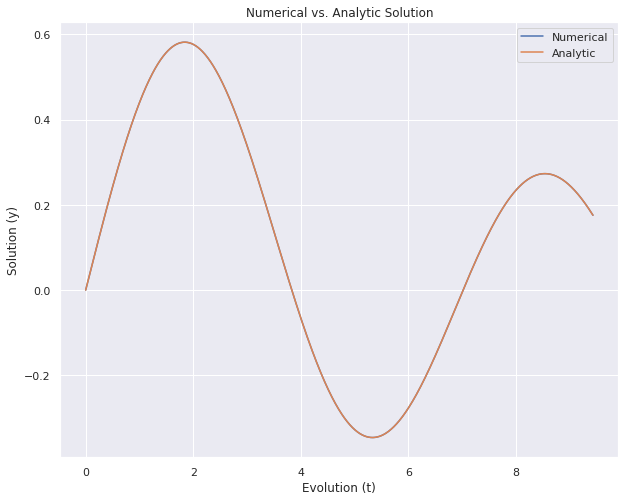

In [56]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
ax.plot(t, u[0,:]*t)
ax.plot(t, J)

ax.set_title('Numerical vs. Analytic Solution')
ax.set_xlabel('Evolution (t)')
ax.set_ylabel('Solution (y)')
ax.legend(['Numerical', 'Analytic']);

Looks like everything went well. We will also consider computing the value $y(3\pi)$ using Repeated Richardson.

In [94]:
h0 = 1
kw = {'f':f, 'y0':u0, 'interval':[0,3*np.pi], 'last':True}

u = extraRich(odeTrap, kw, h0, 2, 2, tol=1e-10)

In [95]:
print(np.abs(3*np.pi*u-sps.jv(1, 3*np.pi)))

5.8455405465007715e-06


Not quite 10 significant digits, but hey...